![CIFAR-10 website.png](<attachment:CIFAR-10 website.png>)
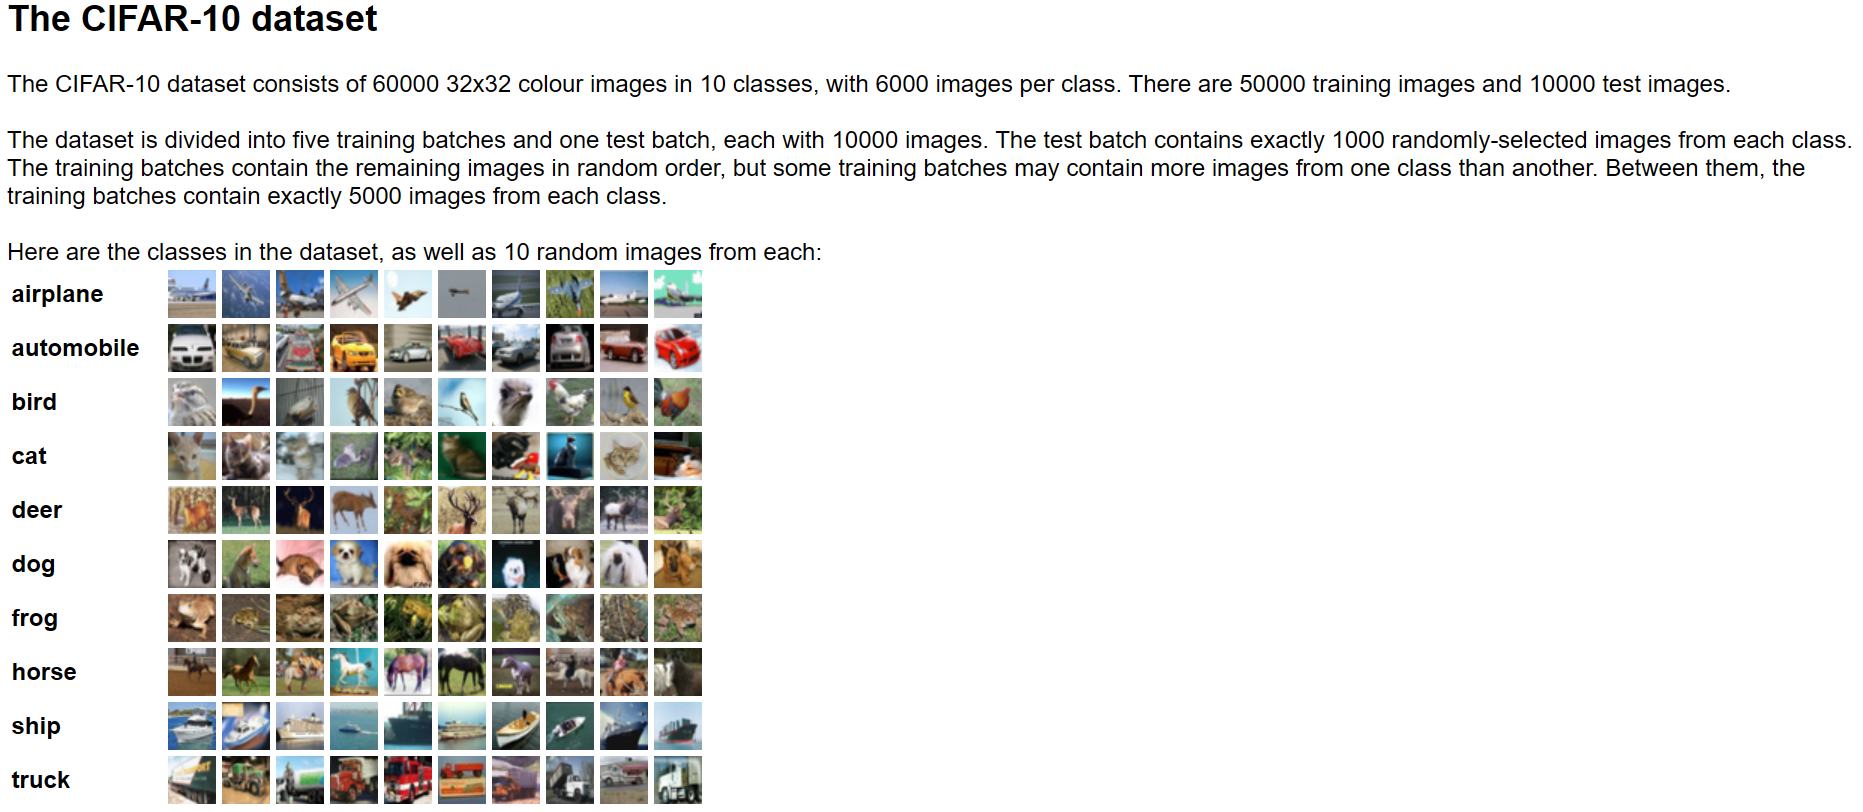

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Activation and loss functions
import torch.optim as optim # Optimization of loss functions

import torchvision
import torchvision.transforms as transforms # Image format modifications

import numpy as np

In [3]:
#Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define the transformation to be applied to the images: each RGB channel from [0, 255] to [-1, 1]
transform = transforms.Compose([
	transforms.ToTensor(), # [0, 255] to tensor [0, 1] with each RGB channel
	transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]) # normalization from [0, 1] to [-1, 1]: normalized value = (input - mean)/SD; e.g. input == 0 -> (0 - 0.5)/0.5 = -1
])

In [ ]:
# Download and load the datasets
train_set = torchvision.datasets.CIFAR10(root = "./data", train = True, transform = transform, download = True) # Dataset included in torchvision. Download and transform the images. 
test_set = torchvision.datasets.CIFAR10(root = "./data", train = False, transform = transform, download = True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True, num_workers = 2) # Divide the data in batches of 32 shuffled images with their corresponding labels. During training, we iterate over the batches, with data loading done by 2 worker processes in parallel
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True, num_workers = 2)

In [6]:
# Now each component contains the normalized RGB values of a tensor image and its label
print(train_set[0], "\n")
tensor_image, label = train_set[0]
print(tensor_image.size(), "== 3 channels (RGB), 32x32 px")
#	Note that the labels are indexes or positions of the following list (starting from "0"): airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

        [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
         [-0.8431, -1.0000, -1.0000,  ..., -

In [7]:
# Create a convolutional neural network
class ConvNN(nn.Module): # nn.Module is a parent class included in torch.nn
	# Define the configuration of the NN's layers to be used in the forward method
	def __init__(self):
		super().__init__() # Call the __init__ method of the parent class nn.Module

		# First convolutional layer
		self.conv1 = nn.Conv2d(3, 24, 5, stride = 1, padding = 2) # 3 input channels, 24 output channels/feature maps (each generated with a different kernel), 5x5 px kernel size
		#	Feature maps' output size = (input size - kernel size + 2 * padding)/stride + 1
		#	If we want output size = input size -> padding = 2
		# Shape: (24, 32, 32) [24 output channels, size: 32x32 (input size = 32)]
		
		# Pooling layer to extract the most important features of the feature maps
		self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # Shape: (24, 16, 16) [still 24 output channels, size: 16x16]  

		# 2nd convolutional layer
		self.conv2 = nn.Conv2d(24, 48, 5, stride = 1, padding = 0) # 24 input channels (the 24 feature maps), 48 output channels/feature maps, 5x5 px kernel size
		# Shape (after output size calculation): (48, 12, 12) [48 output channels, size: 12x12 px (input size = 16)] -> after another MaxPool: (48, 6, 6) -> Flatten (48 * 6 * 6) [number of input features]

		# Fully connected layers
		self.fc1 = nn.Linear(48 * 6 * 6, 120) # Input: shape after the flattening to 1 dimension; 120 neurons
		self.fc2 = nn.Linear(120, 100)
		self.fc3 = nn.Linear(100, 10) # 10 neurons at the end (the number of class names)

		# Dropout layers could be added to prevent overfitting
		#self.dropout = nn.Dropout(0.3) # Takes the values of the previous layer, sets 30% of them to 0. Usually applied after each intermediate fully connected layer
	
	# Define the forward method's steps
	def forward(self, x): # x will be the input image at first
		x = self.pool(F.relu(self.conv1(x))) # 1st convolution layer -> ReLU activation function -> 1st MaxPool layer
		x = self.pool(F.relu(self.conv2(x))) # Same steps using the 2nd convolution layer
		x = torch.flatten(x, 1) # Flattening shape "x" to 1 dimension
		x = F.relu(self.fc1(x)) # Apply the ReLU activation function
		x = F.relu(self.fc2(x))
		x = self.fc3(x) # Do not apply any activation function because the loss function CrossEntropyLoss (below) already applies "log softmax" and, therefore, expects raw logits.
		#	Softmax and log softmax are well-suited for class classifications.
		return x

In [8]:
cnn = ConvNN().to(device) # Initialize the neural network ('cnn' "becomes" 'self' during the execution) and move it to the GPU
# Define the loss function
loss_ft = nn.CrossEntropyLoss()
# Define the method for updating the weights and biases of the network based on the minimization of the loss function
optimizer = optim.Adam(cnn.parameters(), lr = 0.001) # Small learning rate to ensure a stable convergence to a minimum

In [41]:
# Training the neural network
cnn.train() # Set the network to training mode (e.g. allows the correct functioning of dropout layers)
for epoch in range(20):
	print(f"Training epoch {epoch}...")
	running_loss = 0.0
	for data in train_loader:
		input_images, labels = data # Data contains a batch of images and their corresponding labels (batch size is 32 as defined in train_loader above)
		input_images, labels = input_images.to(device), labels.to(device)
		optimizer.zero_grad() # Reset the gradient's parameters for each batch
		predictions = cnn(input_images) # Forward pass of the batch through the network to get the label predictions
		loss_ft_result = loss_ft(predictions, labels) # Calculate the loss between the predictions and the actual labels
		loss_ft_result.backward() # Compute the gradient for the loss function
		optimizer.step() # Update the weights and biases of the network based on the gradient calculations
		running_loss = running_loss + loss_ft_result.item() # Transform loss to float and add it to the loss of the previous batches to calculate the accumulated loss for the epoch
	print(f"Average loss: {running_loss / len(train_loader):.4f}") # Average loss with 4 decimal digits. Lower is better. len(train_loader) is the number of batches

Training epoch 0...
Average loss: 1.4011
Training epoch 1...
Average loss: 1.0141
Training epoch 2...
Average loss: 0.8521
Training epoch 3...
Average loss: 0.7409
Training epoch 4...
Average loss: 0.6551
Training epoch 5...
Average loss: 0.5836
Training epoch 6...
Average loss: 0.5173
Training epoch 7...
Average loss: 0.4595
Training epoch 8...
Average loss: 0.4092
Training epoch 9...
Average loss: 0.3604


In [42]:
# Export the trained network's parameters
torch.save(cnn.state_dict(), "trained_cnn.pth")

In [ ]:
# In case we want to load some previous parameters instead of training the network again

#cnn = ConvNN().to(device)
#cnn.load_state_dict(torch.load("trained_cnn.pth"))

In [36]:
# Evaluate the accuracy of the network
correct = 0
total = 0
cnn.eval() # Set the network to evaluation mode
with torch.no_grad(): # Run the network disabling the gradient computation
	for data in test_loader: # Get batches of images and their labels from the test dataset
		input_images, labels = data
		input_images, labels = input_images.to(device), labels.to(device)
		predictions = cnn(input_images)
		_, predicted = torch.max(predictions, dim = 1) # "predictions" is a 2D tensor (array) and each row contains the values of the 10 final neurons for each image.
		#	To access rows, dim must be 1.
		#	torch.max is used to get the max value of each row (the class with the most probability for each image).
		#	The output is: <tensor (array) with the max value for each row>, <tensor (array) with the position in each row of each max value>. We only want to know the class/label of the image (using the position in the row), so the first output is "_".
		total = total + labels.size(dim = 0) # Dimension 0 is the batch size. Each time a batch is processed, its number of images is added to the total number of analyzed images
		correct = correct + (predicted == labels).sum().item() # Compare the labels array from the batch with the array of predictions and add the number of labels that coincide.
		#	"True" if the labels coincide and "False" if not.
		#	Conversion by .sum(): True -> 1, False -> 0, obtaining a tensor (array) of "1s" and "0s", which are added, returning a single number of correct answers.
		#	.item() converts the tensor (int) into a common int
accuracy = 100 * correct / total
print(f"Overall accuracy: {accuracy}%")

Overall accuracy: 70.9%


In [84]:
import matplotlib.pyplot as plt # Used for plotting images later on
from PIL import Image # Used for loading images in different formats

In [52]:
# Function to open normalized images with NumPy
def tensor_to_numpy(img):
	img = img.cpu() * 0.5 + 0.5 # Unnormalize using the formula for normalization above: normalized value = (unnormalized value - mean)/SD.
	#	Transfering the image to the CPU is needed to access it for plotting later on
	npimg = img.numpy() # Convert tensor (image) into a NumPy array
	npimg = np.transpose(npimg, (1, 2, 0)) # Converted tensor images return "(channels, height, width)", but libraries process this information in the opposite order -> transpose needed
	return npimg

In [85]:
# Open any image from a directory

# Same transformation as before but resizing the images to 32x32
new_transform = transforms.Compose([
	transforms.Resize((32, 32)),
	transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to load images from a path
def load_image(image_path):
	image = Image.open(image_path)
	image = new_transform(image) # Apply the new transform to ensure external images match the dataset format
	return image

----------------
Images from CIFAR10 evaluation DATASET
----------------



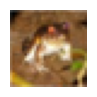

Label: frog
Predicted label: frog


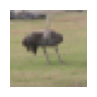

Label: bird
Predicted label: bird

----------------
Images from PATH
----------------



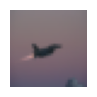

Predicted label: airplane


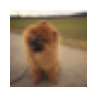

Predicted label: dog


In [90]:
# Test the neural network on two images from the test set

# Define an array with the classes to access them
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Crate an array with the paths of each image outside the dataset
image_paths = ['test1.jpg', 'test2.jpg']

# Extract two images from the test set
image1, label1 = train_set[0]
image2, label2 = train_set[42]

# Create an array with the labels from the test set
dataset_labels = [label1, label2]

# Create an array with the image tensors
image_tensors_array = [image1, image2]
for path in image_paths:
	external_image = load_image(path)
	image_tensors_array.append(external_image)

# Make a batch with each image (since the network expects batches)
for i in range(len(image_tensors_array)):
    image_tensors_array[i] = image_tensors_array[i].unsqueeze(0)

# Pass the images through the network
cnn.eval()
with torch.no_grad():
	for i, image in enumerate(image_tensors_array):
		if i == 0:
			print("----------------\nImages from CIFAR10 evaluation DATASET\n----------------\n")
		if i == 2:
			print("\n----------------\nImages from PATH\n----------------\n")
		image = image.to(device) # Transfer the image to the GPU
		prediction = cnn(image)
		_, predicted_label = torch.max(prediction, dim = 1)

		# Plot image with matplotlib
		fig, ax = plt.subplots(figsize = (1, 1), facecolor = "none")
		ax.imshow(tensor_to_numpy(image.squeeze(0))) # Transform the batch with the tensor (image) to just a tensor (image) and convert it to a NumPy image and plot it
		ax.axis('off')
		ax.set_xticks([])
		ax.set_yticks([])
		plt.show()

		if i < 2:
			print(f"Label: {class_names[dataset_labels[i]]}")
		print(f"Predicted label: {class_names[predicted_label.item()]}")